# Predicting Car Accident Severity

### Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_27c2b903c64d44afa7326cf2c08f752e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='UOpW0nffne37I7Lcv7p58gtiB9dzGVYAonldvoail3R9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_27c2b903c64d44afa7326cf2c08f752e.get_object(Bucket='predictingcaraccidentseverity-donotdelete-pr-gmll2k2sqmrid8',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Dropping nonrelvant attributes

In [3]:
df_data_1 = df_data_1.drop(['OBJECTID','INCKEY','LOCATION','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE',
              'EXCEPTRSNDESC','SEVERITYDESC','INCDATE','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE',
              'ST_COLDESC','SEGLANEKEY','CROSSWALKKEY','INCDTTM'],axis=1)
df_data_1.columns

Index(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'SEVERITYCODE.1', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR'],
      dtype='object')

### Retrieving missing value

In [4]:
def missing_function(df_data_1):
    missing_data = df_data_1.isnull()
    missing_data.head()

    for column in missing_data.columns.values.tolist():
        print(column)
        print(missing_data[column].value_counts())
        print(df_data_1[column].value_counts())
        print("")
        
missing_function(df_data_1)

SEVERITYCODE
False    194673
Name: SEVERITYCODE, dtype: int64
1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

X
False    189339
True       5334
Name: X, dtype: int64
-122.332653    265
-122.344896    254
-122.328079    252
-122.344997    239
-122.299160    231
-122.351134    212
-122.347294    190
-122.345863    163
-122.332451    160
-122.269988    152
-122.329049    147
-122.310949    146
-122.289923    142
-122.334666    138
-122.339174    136
-122.321920    136
-122.329974    135
-122.335571    133
-122.302329    132
-122.324615    131
-122.269982    130
-122.339439    129
-122.339559    129
-122.316733    128
-122.333757    128
-122.277664    128
-122.323239    126
-122.334792    125
-122.327525    121
-122.287546    121
              ... 
-122.339360      1
-122.350751      1
-122.290428      1
-122.360492      1
-122.346878      1
-122.373860      1
-122.394434      1
-122.291681      1
-122.301697      1
-122.354259      1
-122.386178      1
-122.390046      1
-122.36

### Handling missing values

In [6]:
df_data_1.replace(r'^\s*$', np.nan, regex=True)
df_data_1.replace("Unknown", np.nan, inplace = True)
df_data_1.replace("Other", np.nan, inplace = True)

#dropping columns with more than 20% values missing (INATTENTIONIND,PEDROWNOTGRNT,SPEEDING)
df_data_1 = df_data_1.drop(["INATTENTIONIND","PEDROWNOTGRNT","SPEEDING"],axis=1)

#dropping rows for columns with less than 20% values missing (X, Y,COLLISIONTYPE,JUNCTIONTYPE,
                                                            #UNDERINFL,WEATHER,ROADCOND,LIGHTCOND)
df_data_1.dropna(subset=["X","Y","COLLISIONTYPE","JUNCTIONTYPE","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND"], 
          axis=0, inplace=True)

#making sure all missing values are handled with
print(df_data_1.info())
missing_function(df_data_1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143747 entries, 0 to 194672
Data columns (total 16 columns):
SEVERITYCODE      143747 non-null int64
X                 143747 non-null float64
Y                 143747 non-null float64
ADDRTYPE          143747 non-null object
SEVERITYCODE.1    143747 non-null int64
COLLISIONTYPE     143747 non-null object
PERSONCOUNT       143747 non-null int64
PEDCOUNT          143747 non-null int64
PEDCYLCOUNT       143747 non-null int64
VEHCOUNT          143747 non-null int64
JUNCTIONTYPE      143747 non-null object
UNDERINFL         143747 non-null object
WEATHER           143747 non-null object
ROADCOND          143747 non-null object
LIGHTCOND         143747 non-null object
HITPARKEDCAR      143747 non-null object
dtypes: float64(2), int64(6), object(8)
memory usage: 18.6+ MB
None
SEVERITYCODE
False    143747
Name: SEVERITYCODE, dtype: int64
1    94821
2    48926
Name: SEVERITYCODE, dtype: int64

X
False    143747
Name: X, dtype: int64
-122.328079

In [7]:
df_data_1['SEVERITYCODE'].value_counts()

1    94821
2    48926
Name: SEVERITYCODE, dtype: int64

###  Balancing the Dataset

In [8]:
#shuffling and creating a balanced dataset
df_data_1 = df_data_1.sample(frac=1,random_state=0,replace=False)

# 1 - Put all severity code 2 class in a separate dataset.
df_data_1_scode2 = df_data_1.loc[df_data_1['SEVERITYCODE'] == 2]

# 2 - Randomly select 58188 observations from the severity code 1(majority class)
df_data_1_scode1 = df_data_1.loc[df_data_1['SEVERITYCODE'] == 1].sample(n=48926,random_state=42)

# 3 - concatenating datasets to get balanced dataset
df_data_1_balanced = pd.concat([df_data_1_scode1,df_data_1_scode2])
df_data_1_balanced = df_data_1_balanced.sample(frac=1,random_state=0,replace=False)

#Replacing 0 with N and 1 with Y as this column has mixed datatype values, making it consistent
df_data_1_balanced['UNDERINFL'] = df_data_1_balanced['UNDERINFL'].replace(['0'],'N')
df_data_1_balanced['UNDERINFL'] = df_data_1_balanced['UNDERINFL'].replace(['1'],'Y')

#checking if dataset balanced
print(df_data_1_balanced.info())
print(df_data_1_balanced['SEVERITYCODE'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97852 entries, 139054 to 72625
Data columns (total 16 columns):
SEVERITYCODE      97852 non-null int64
X                 97852 non-null float64
Y                 97852 non-null float64
ADDRTYPE          97852 non-null object
SEVERITYCODE.1    97852 non-null int64
COLLISIONTYPE     97852 non-null object
PERSONCOUNT       97852 non-null int64
PEDCOUNT          97852 non-null int64
PEDCYLCOUNT       97852 non-null int64
VEHCOUNT          97852 non-null int64
JUNCTIONTYPE      97852 non-null object
UNDERINFL         97852 non-null object
WEATHER           97852 non-null object
ROADCOND          97852 non-null object
LIGHTCOND         97852 non-null object
HITPARKEDCAR      97852 non-null object
dtypes: float64(2), int64(6), object(8)
memory usage: 12.7+ MB
None
2    48926
1    48926
Name: SEVERITYCODE, dtype: int64


### Performing Train Test Split of dataset

In [9]:
X = df_data_1_balanced.iloc[:,1:]

#Encoding Categorical Features - Training Dataset
X = pd.get_dummies(data=X, columns=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','WEATHER',
                                                            'ROADCOND','LIGHTCOND','UNDERINFL','HITPARKEDCAR'])

Y = df_data_1_balanced[['SEVERITYCODE']]
print(X.info())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 97852 entries, 139054 to 72625
Data columns (total 51 columns):
X                                                                 97852 non-null float64
Y                                                                 97852 non-null float64
SEVERITYCODE.1                                                    97852 non-null int64
PERSONCOUNT                                                       97852 non-null int64
PEDCOUNT                                                          97852 non-null int64
PEDCYLCOUNT                                                       97852 non-null int64
VEHCOUNT                                                          97852 non-null int64
ADDRTYPE_Block                                                    97852 non-null uint8
ADDRTYPE_Intersection                                             97852 non-null uint8
COLLISIONTYPE_Angles                                              97852 non-null uint8
COLLISIONTYP

### Normalizing/Feature Scaling

In [10]:
#Scaling training data as per the requirements
scaler = StandardScaler()
X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_train[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

#Scaling test data as per the requirements
scaler = StandardScaler()
X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']] = scaler.fit_transform(
    X_test[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

X_train.info()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78281 entries, 157089 to 61252
Data columns (total 51 columns):
X                                                                 78281 non-null float64
Y                                                                 78281 non-null float64
SEVERITYCODE.1                                                    78281 non-null int64
PERSONCOUNT                                                       78281 non-null float64
PEDCOUNT                                                          78281 non-null float64
PEDCYLCOUNT                                                       78281 non-null float64
VEHCOUNT                                                          78281 non-null float64
ADDRTYPE_Block                                                    78281 non-null uint8
ADDRTYPE_Intersection                                             78281 non-null uint8
COLLISIONTYPE_Angles                                              78281 non-null uint8
COLL

### Plotting the  Heatmap

In [11]:
df_data_1_corr = pd.concat([Y_train,X_train])
df_data_1_corr = df_data_1_corr.corr()
#df_data_1_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


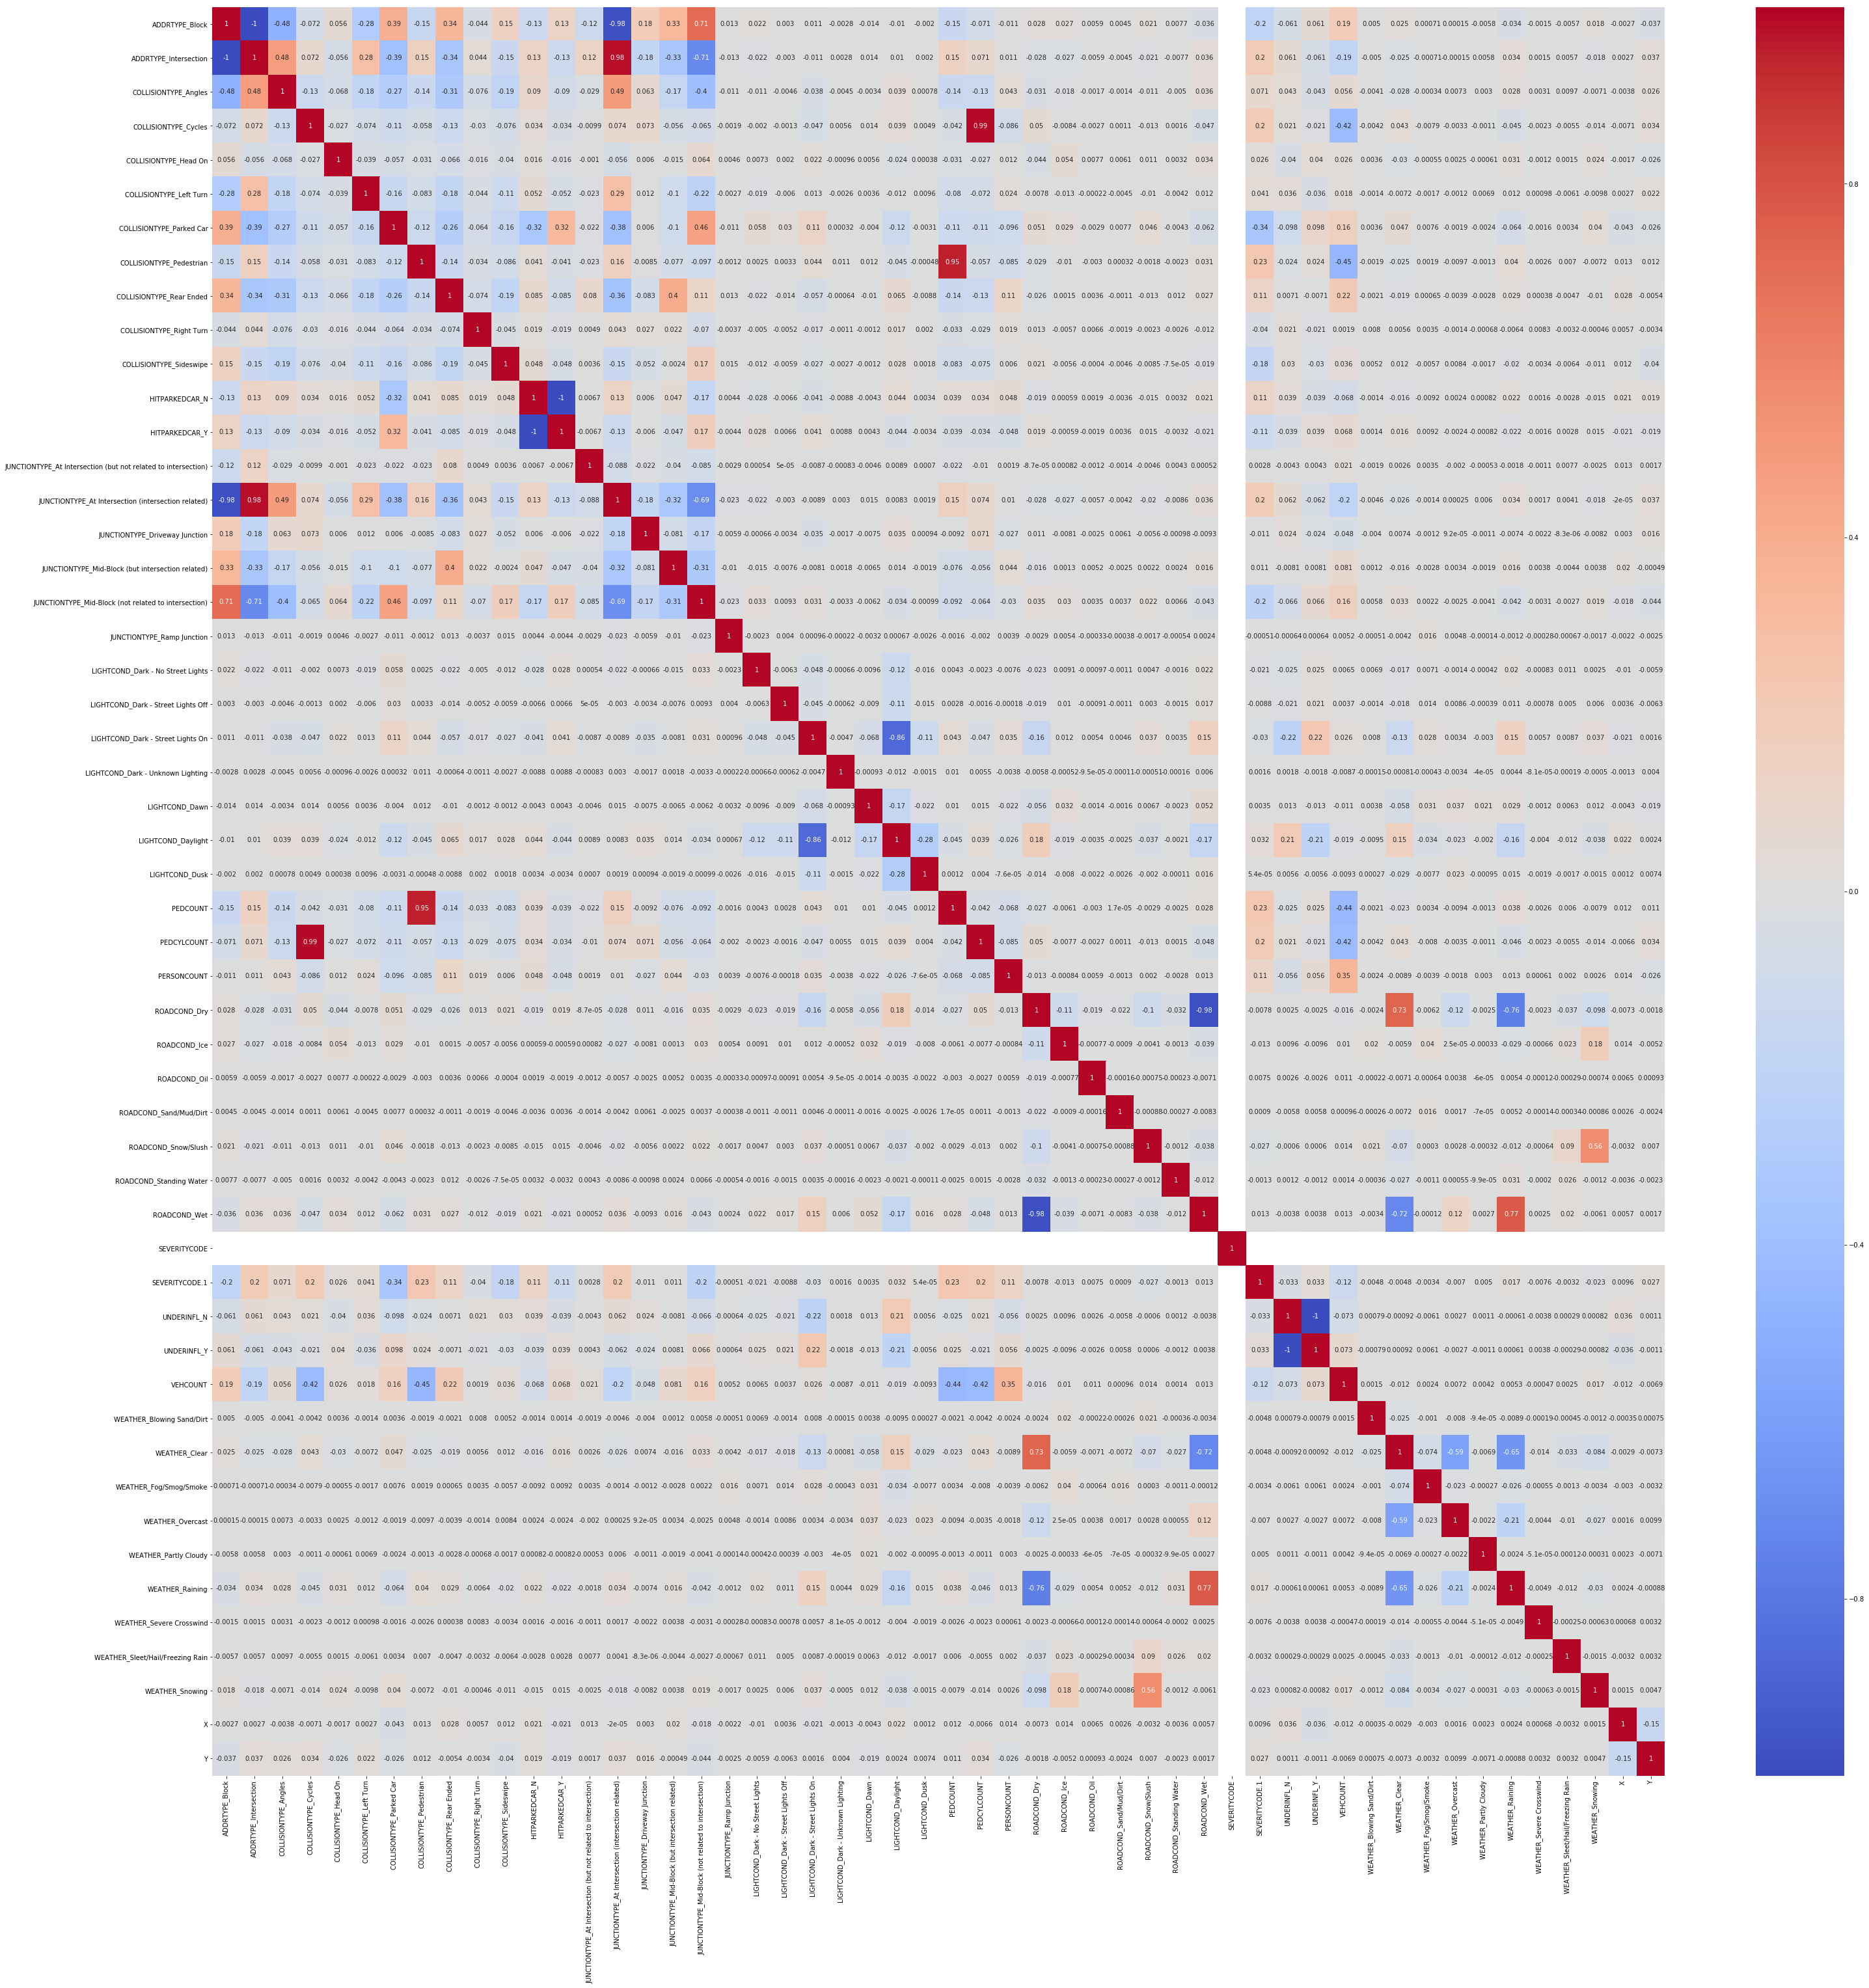

In [12]:
plt.figure(figsize=(50,50))
seaborn.heatmap(df_data_1_corr,annot=True,cmap='coolwarm')
plt.savefig('corr.png')
#seaborn.pairplot(df_data_1_normalized)

In [13]:
missing_function(X_train)
print(X_train.info())
print(X_test.info())

X
False    78281
Name: X, dtype: int64
 0.075985    131
-0.079468    107
 1.058683    106
-0.072604    105
-0.495493    103
-0.498915     93
-0.576986     89
-0.707460     83
-0.147849     82
 0.461508     80
 1.789128     79
 0.043020     76
-0.178717     74
-0.301036     70
-0.116967     69
 0.047628     68
 2.049974     67
 0.011577     66
 0.658055     65
 2.050174     65
 1.210334     63
 0.945189     63
-0.410737     62
 0.320843     62
-0.179142     62
-1.247411     60
 0.053731     60
-0.528353     60
-0.094780     59
 0.285248     59
            ... 
-0.035194      1
 0.068360      1
 1.531017      1
-0.484683      1
-1.397400      1
-1.401807      1
-0.265097      1
 2.417609      1
-1.670877      1
-0.172723      1
 2.174158      1
 0.858653      1
-1.026414      1
-1.861056      1
 0.204036      1
-1.304914      1
 2.659045      1
-0.358015      1
 0.920189      1
 2.052808      1
 0.863206      1
-0.487752      1
 0.733140      1
 1.637045      1
 1.316695      1
 0.603848

0    78270
1       11
Name: ROADCOND_Oil, dtype: int64

ROADCOND_Sand/Mud/Dirt
False    78281
Name: ROADCOND_Sand/Mud/Dirt, dtype: int64
0    78266
1       15
Name: ROADCOND_Sand/Mud/Dirt, dtype: int64

ROADCOND_Snow/Slush
False    78281
Name: ROADCOND_Snow/Slush, dtype: int64
0    77968
1      313
Name: ROADCOND_Snow/Slush, dtype: int64

ROADCOND_Standing Water
False    78281
Name: ROADCOND_Standing Water, dtype: int64
0    78251
1       30
Name: ROADCOND_Standing Water, dtype: int64

ROADCOND_Wet
False    78281
Name: ROADCOND_Wet, dtype: int64
0    57442
1    20839
Name: ROADCOND_Wet, dtype: int64

LIGHTCOND_Dark - No Street Lights
False    78281
Name: LIGHTCOND_Dark - No Street Lights, dtype: int64
0    77756
1      525
Name: LIGHTCOND_Dark - No Street Lights, dtype: int64

LIGHTCOND_Dark - Street Lights Off
False    78281
Name: LIGHTCOND_Dark - Street Lights Off, dtype: int64
0    77819
1      462
Name: LIGHTCOND_Dark - Street Lights Off, dtype: int64

LIGHTCOND_Dark - Street Light

#  ML Algorithms

### Logistic Regression

In [14]:
#Fitting and Predictions
lr = LogisticRegression(random_state = 0)
lr.fit(X_train,Y_train)
lr_predictions = lr.predict(X_test)

#Confusion Matrix
lr_cm = confusion_matrix(Y_test,lr_predictions)
print(lr_cm,'\n')

#Classification Report
lr_cr = classification_report(Y_test,lr_predictions)
print(lr_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,lr_predictions)
print(acc,'\n')
accDict = {}
accDict['LR'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[9847    0]
 [   0 9724]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      9847
           2       1.00      1.00      1.00      9724

   micro avg       1.00      1.00      1.00     19571
   macro avg       1.00      1.00      1.00     19571
weighted avg       1.00      1.00      1.00     19571
 

1.0 



## Decision Tree Classifier

In [15]:
#Fitting and Predictions
dtc = DecisionTreeClassifier()
params = {'criterion':['gini', 'entropy'], 
          'random_state':[0]}
dtc1 = GridSearchCV(dtc, param_grid=params)
dtc1.fit(X_train,Y_train)
dtc_predictions = dtc1.predict(X_test)
print('Best Hyperparameter DTC : ',dtc1.best_params_)

#Confusion Matrix
dtc_cm=confusion_matrix(Y_test,dtc_predictions)
print(dtc_cm,'\n')

#Classification Report
dtc_cr = classification_report(Y_test,dtc_predictions)
print(dtc_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,dtc_predictions)
print(acc,'\n')
accDict['DTC'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyperparameter DTC :  {'criterion': 'gini', 'random_state': 0}
[[9847    0]
 [   0 9724]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      9847
           2       1.00      1.00      1.00      9724

   micro avg       1.00      1.00      1.00     19571
   macro avg       1.00      1.00      1.00     19571
weighted avg       1.00      1.00      1.00     19571
 

1.0 



### K-Nearest Neighbors

In [16]:
#Fitting and Predictions
nb = GaussianNB()
nb.fit(X_train,Y_train)
nb_predictions = nb.predict(X_test)

#Confusion Matrix
nb_cm=confusion_matrix(Y_test,nb_predictions)
print(nb_cm,'\n')

#Classification Report
nb_cr = classification_report(Y_test,nb_predictions)
print(nb_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,nb_predictions)
print(acc,'\n')
accDict['NB'] = acc


[[9847    0]
 [   0 9724]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      9847
           2       1.00      1.00      1.00      9724

   micro avg       1.00      1.00      1.00     19571
   macro avg       1.00      1.00      1.00     19571
weighted avg       1.00      1.00      1.00     19571
 

1.0 



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Random Forest Classifier

In [17]:
#Fitting and Predictions
rf = RandomForestClassifier()
params = {'n_estimators':[50,75,100],
          'criterion':['gini', 'entropy'], 
          'random_state':[0]}
rf1 = GridSearchCV(rf, param_grid=params)
rf1.fit(X_train,Y_train)
rf_predictions = rf1.predict(X_test)
print('Best Hyperparameter RFT : ',rf1.best_params_)

#Confusion Matrix
rf_cm=confusion_matrix(Y_test,rf_predictions)
print(rf_cm,'\n')

#Classification Report
rf_cr = classification_report(Y_test,rf_predictions)
print(rf_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,rf_predictions)
print(acc,'\n')
accDict['RFT'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWa

Best Hyperparameter RFT :  {'criterion': 'gini', 'n_estimators': 50, 'random_state': 0}
[[9847    0]
 [   0 9724]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      9847
           2       1.00      1.00      1.00      9724

   micro avg       1.00      1.00      1.00     19571
   macro avg       1.00      1.00      1.00     19571
weighted avg       1.00      1.00      1.00     19571
 

1.0 



### Support-Vector Machine

In [18]:

#Fitting and Predictions
svc = SVC()
params = {'kernel':['linear','rbf'], 
          'random_state':[0]}
svc1 = GridSearchCV(svc, param_grid=params)
svc1.fit(X_train,Y_train)
svc_predictions = svc1.predict(X_test)
print('Best Hyperparameter SVM : ',svc1.best_params_)

#Confusion Matrix
svc_cm=confusion_matrix(Y_test,svc_predictions)
print(svc_cm,'\n')

#Classification Report
svc_cr = classification_report(Y_test,svc_predictions)
print(svc_cr,'\n')

#Accuracy
acc = accuracy_score(Y_test,svc_predictions)
print(acc,'\n')
accDict['SVC'] = acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expec

Best Hyperparameter SVM :  {'kernel': 'linear', 'random_state': 0}
[[9847    0]
 [   0 9724]] 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      9847
           2       1.00      1.00      1.00      9724

   micro avg       1.00      1.00      1.00     19571
   macro avg       1.00      1.00      1.00     19571
weighted avg       1.00      1.00      1.00     19571
 

1.0 



### Plotting Results 

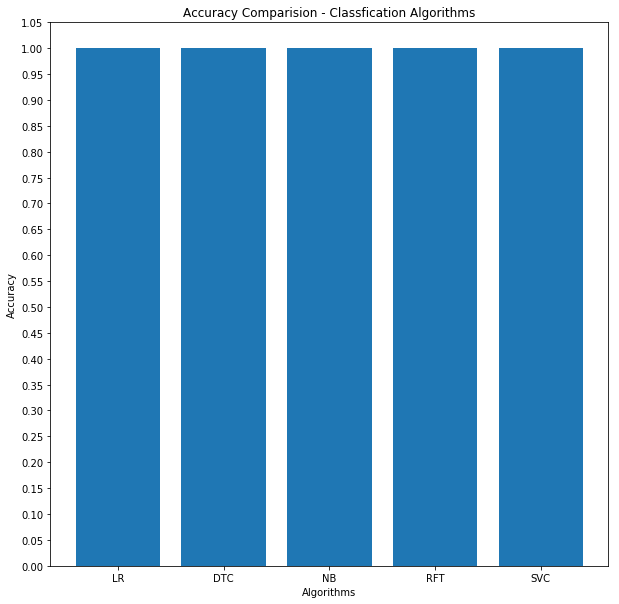

In [19]:
accDict = sorted(accDict.items(), key=lambda x: x[1], reverse=True)
dict1 = {}
for elem in accDict:
    dict1[elem[0]] = elem[1]
Algorithms = dict1.keys()
Accuracy = dict1.values()
plt.figure(figsize=(10,10))
plt.bar(Algorithms, Accuracy)
plt.xlabel('Algorithms')
plt.yticks(np.arange(0,max(Accuracy)+0.1,0.05))
plt.ylabel('Accuracy')
plt.title('Accuracy Comparision - Classfication Algorithms')
plt.show()